In [188]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2


In [189]:
# sorting data from a file
datapath = "output/eye_data.csv"

# convert to dataframe
import pandas as pd
df = pd.read_csv(datapath)

df.head()

# open the output fodler and read all of the files

# create a list of all the image files
# and their labels
image_numbers = df['frame_idx'].tolist()
# load image
print("image_numbers", image_numbers[-1])

images = []
for frame_num in image_numbers:
    image_path = f"output/{frame_num}.png"
    print("image_path", image_path)
    image = cv2.imread(image_path)
    if image is None:
        continue
    # convert to grayscale
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # resize the image to 128x128
    image = cv2.resize(image, (128, 128))
    images.append(image)



image_numbers 677
image_path output/1.png
image_path output/2.png
image_path output/3.png
image_path output/4.png
image_path output/5.png
image_path output/6.png
image_path output/7.png
image_path output/8.png
image_path output/9.png
image_path output/10.png
image_path output/11.png
image_path output/12.png
image_path output/13.png
image_path output/14.png
image_path output/15.png
image_path output/16.png
image_path output/17.png
image_path output/18.png
image_path output/27.png
image_path output/28.png
image_path output/29.png
image_path output/30.png
image_path output/31.png
image_path output/32.png
image_path output/33.png
image_path output/34.png
image_path output/35.png
image_path output/36.png
image_path output/37.png
image_path output/38.png
image_path output/39.png
image_path output/40.png
image_path output/41.png
image_path output/42.png
image_path output/43.png
image_path output/44.png
image_path output/45.png
image_path output/46.png
image_path output/47.png
image_path outpu

C:\Users\NateLy\AppData\Local\Temp\ipykernel_14452\1125505801.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '127.99999999999999' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.at[entry[0], param] = entry[1][param] * ratio
C:\Users\NateLy\AppData\Local\Temp\ipykernel_14452\1125505801.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '127.99999999999999' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.at[entry[0], param] = entry[1][param] * ratio


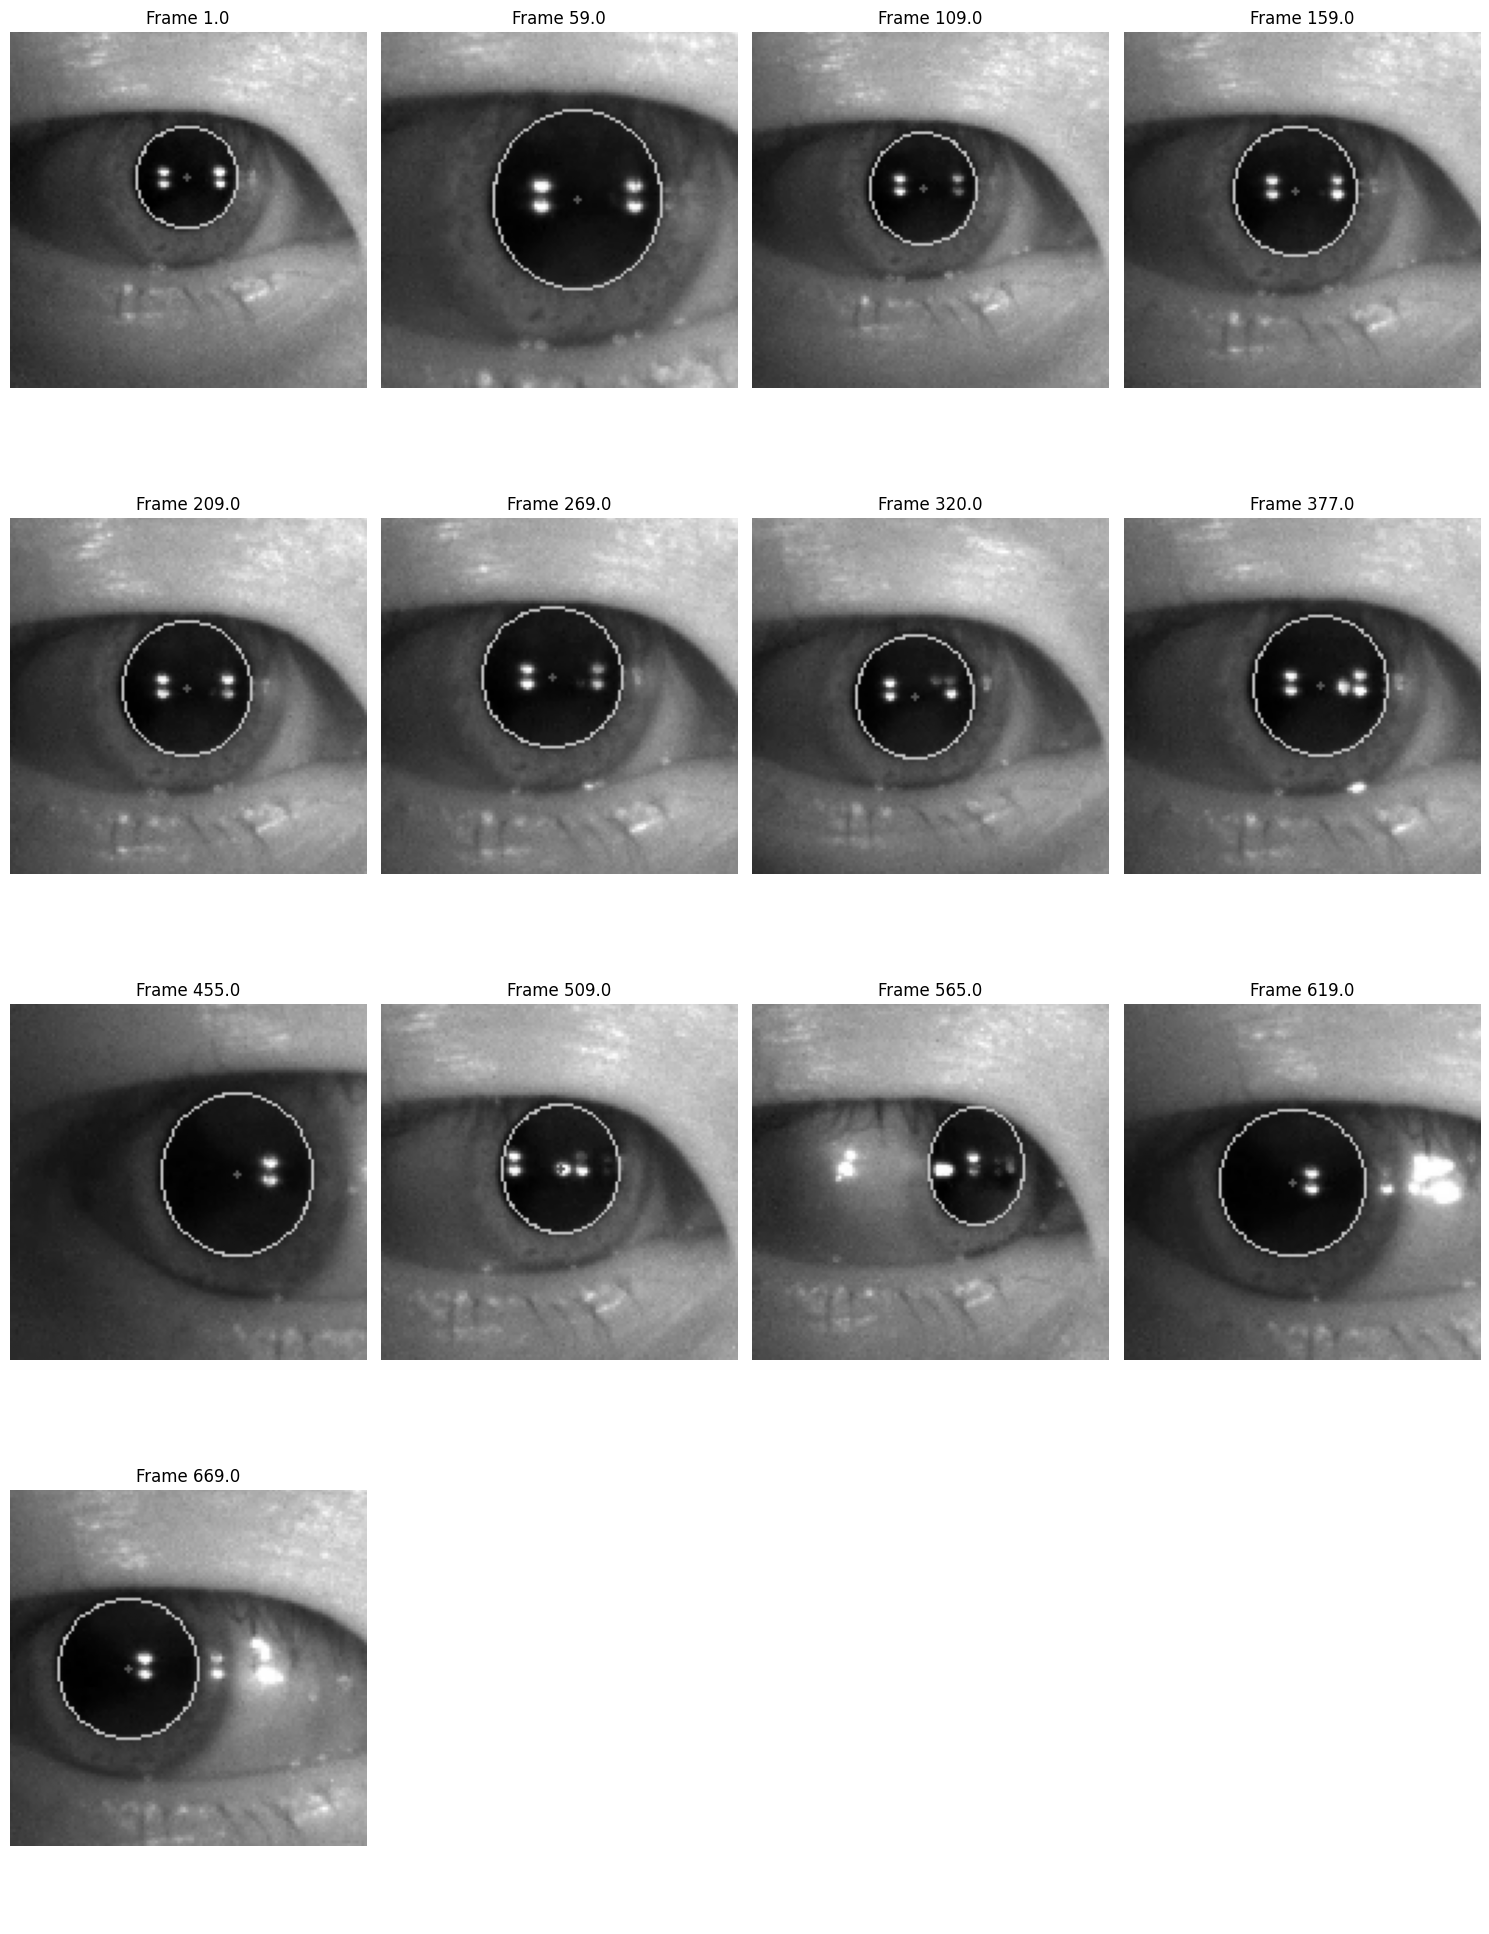

In [190]:
# for entry in dataframe

for entry in df.iterrows():

    num = entry[1]['frame_idx']
    size = entry[1]['h']
    ratio = 128/size
    params = ['ellipse_h', 'ellipse_w', 'ellipse_x', 'ellipse_y', 'w', 'h']
    for param in params:
        df.at[entry[0], param] = entry[1][param] * ratio
        

selected_indices = [i for i in range(len(images)) if i % 50 == 0]
n = len(selected_indices)

# Define grid size (e.g., 3 columns)
cols = 4
rows = (n + cols - 1) // cols  # ceiling division

fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
axes = axes.flatten()

for idx, i in enumerate(selected_indices):
    image = images[i].copy()
    entry = df.iloc[i]

    ellipse_x = int(entry['ellipse_x'])
    ellipse_y = int(entry['ellipse_y'])
    ellipse_w = int(entry['ellipse_w'] / 2)
    ellipse_h = int(entry['ellipse_h'] / 2)

    cv2.ellipse(image, (ellipse_x, ellipse_y), (ellipse_w, ellipse_h), 0, 0, 360, (200, 100, 0), 1)
    cv2.circle(image, (ellipse_x, ellipse_y), 1, (100, 100, 100), -1)

    axes[idx].imshow(image, cmap='gray')
    axes[idx].set_title(f"Frame {entry['frame_idx']}")
    axes[idx].axis('off')

# Hide any unused subplots
for j in range(idx + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# IMAGES
# image 